<a href="https://colab.research.google.com/github/leejielong/hdbnet/blob/master/HDBnet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HDBnet - EDA

In this notebook we will explore the HDB resale dataset, perform data cleaning and feature engineering in preparation for regressive modelling. Our objective is to achieve an MAE of less than 15k SGD so that we can provide a useful valuation for prospective buyers or sellers to estimate the valuation of their unit.

###Dependencies

In [ ]:
!pip install --quiet aiohttp nest_asyncio neptune-client

from google.colab import drive
import pandas as pd
import time
from datetime import datetime
import os
import io
import random
import pickle
from zipfile import ZipFile 

import urllib
import aiohttp
import nest_asyncio
import asyncio
import json
from geopy import distance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_absolute_error

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

import neptune.new as neptune

#rebuild all pickle files
data_refresh = False

In [ ]:
try:
    drive.mount('/content/drive')
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

##Data Ingestion
The HDB resale price transaction records provides data on all resale flat transactions from 1990 till present. The transaction data from data.gov.sg comes in a zip file containing five csv files. The 30-year records are split across the five files by 1990-2000, 2000-2012, 2012-2014, 2015-2016 and 2017-2021. To maintain relevance of the dataset to recent price trends, we will only utilise 2017-present data. 

As our objective is to predict the latest valuation price for any given HDB unit, it is useful to only feed the model with more recent data. Intuitively, there should be very few if not no blocks encountering zero transactions over the past five years. Even if there are few transaction data for some blocks, these data points are much more relevant to the valuation compared to older transaction prices, since older pricing take into account the economic condition, resale market sentiment and housing policy effects of a different time. Having a large proportion of older resale data may skew the model to perform better at predicting past prices than recent prices.

In [ ]:
import zipfile
drive_path = 'drive/MyDrive/Projects/HDBnet2/'
filename = "download"
if (not os.path.isfile(drive_path+filename) or data_refresh):
    os.system('wget https://data.gov.sg/dataset/7a339d20-3c57-4b11-a695-9348adfd7614/download -P '+drive_path)
    with zipfile.ZipFile(drive_path+filename, 'r') as zipped: 
        zipped.printdir() 
        zipped.extractall(drive_path) 

In [ ]:
df_hdb = pd.read_csv(drive_path+'resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [ ]:
display(df_hdb.head())

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


## Data Cleaning
We can observe some pecularities in the datasets.
* `remaining_lease`: The column lists the years and months remaining at the point of sale. We can convert it to a numerical column.
* `storey_range`: Some units are assigned '01 TO 05', while others are '01 TO 03'. The unit levels are not always categorized in groups of 3 levels. We will need to record the min and max levels, and assign each unit a specific level based on a random sample.

In [ ]:
def extract_year_month(df):
    df['year'] = df['month'].str[0:4].astype(int)
    df['month'] = df['month'].str[-2:].astype(int)
    return(df)

# Prepare year and month for dataset
df_hdb = extract_year_month(df_hdb)

# Extract remaining lease year from dataset
df_hdb['remaining_lease'] = df_hdb['remaining_lease'].str[:2].astype('int')

# Random uniform sample from storey range
df_hdb['storey'] = df_hdb['storey_range'].apply(lambda x: random.choice(range(int(x[0:2]), int(x[-2:]))))

In [ ]:
display(df_hdb.head())

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,storey
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61,232000.0,2017,11
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60,250000.0,2017,2
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,262000.0,2017,1
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62,265000.0,2017,4
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,265000.0,2017,1


###**Missing Data**

We need to identify missing values, and impute or remove these examples before proceeding. 

Observations: There are no missing fields in this dataset.

In [ ]:
df_eda = df_hdb.copy()
df_eda.describe()

,month,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,year,storey
count,98799.000000,98799.000000,98799.000000,98799.000000,9.879900e+04,98799.000000,98799.000000
mean,6.434458,97.777397,1994.658478,74.388678,4.485947e+05,2018.829644,8.163352
std,3.411268,24.209045,13.184882,13.128133,1.559084e+05,1.307450,5.863686
min,1.000000,31.000000,1966.000000,44.000000,1.400000e+05,2017.000000,1.000000
25%,3.000000,82.000000,1984.000000,64.000000,3.358880e+05,2018.000000,4.000000
50%,6.000000,95.000000,1995.000000,74.000000,4.180000e+05,2019.000000,7.000000
75%,9.000000,113.000000,2004.000000,84.000000,5.260000e+05,2020.000000,11.000000
max,12.000000,249.000000,2019.000000,97.000000,1.258000e+06,2021.000000,50.000000


##Exploratory Data Analysis


###Correlation Analysis

In this chapter, we explore the relationships of the features with respect to the target variable `resale_price`.


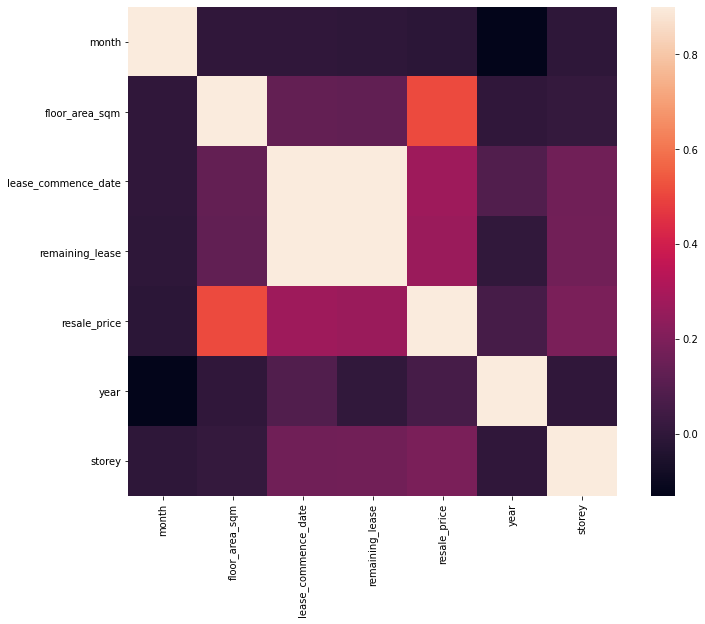

In [ ]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = df_eda.corr(method='kendall')
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

####**Numerical Features**

We start with basic correlation table first to look out for linear relations between different features.

<br />

**Observations:**

*   Remaining_lease is perfectly correlated with lease_commence_date. It makes sense, since remaining_lease = year_of_sale - lease_commence_date + 99.
*   There is strong positive correlation between resale price and floor area. This is intuitive- larger areas typically command higher prices.

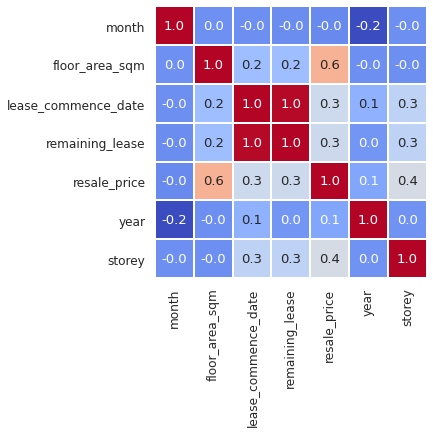

In [ ]:
# Display numerical-to-numerical correlations (pearson correlation) between features on heatmap
sns.set(font_scale=1.1)
correlation_data = df_eda.corr()
mask = np.triu(correlation_data.corr())
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_data,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            linewidths=1,
            cbar=False)

plt.show()

**Observations:**


*   Month: Month as a feature has close to no effect on the resale price.
*   Year: The year of sale has a slight upward trend, with resale prices increasing slightly over the years
* Remaining_lease: Units with higher remaining lease tend to sell for higher. However, there is a drop off for units with less than 88 years lease. Following which, remaining_lease has little effect on resale price only until it dips below the 60 year mark. From there onwards, there is a steep decrease in resale value as the flat ages.





In [ ]:
# # Plotting numerical features with polynomial order to detect outliers by eye.
# def srt_reg(y, df, exclude_columns=[]):

#     num_col_names = df.drop(columns=exclude_columns).select_dtypes(include=['number']).columns
#     num_num = len(list(num_col_names))

#     print(f'plotting columns: {num_col_names}')

#     fig, axes = plt.subplots(num_num, 1, figsize=(20, 40))
#     axes = axes.flatten()

#     for i, j in zip(num_col_names, axes):
#         print(f'plotting column: {i}')
#         sns.regplot(x=i,
#                     y=y,
#                     data=df,
#                     ax=j,
#                     order=3,
#                     ci=None,
#                     color='#e74c3c',
#                     line_kws={'color': 'black'},
#                     scatter_kws={'alpha':0.4})
#         j.tick_params(labelrotation=45)
#         j.yaxis.set_major_locator(MaxNLocator(nbins=10))

#         plt.tight_layout()

# srt_reg('resale_price', df_eda)

####**Categorical Features**

We have checked the pearson correlation of the numerical features using the correlation heatmap. We will also need to observe relations between the categorical data and resale price.

**Observations:**


In [ ]:
# def srt_box(y, df,exclude_columns=[]):
    
#     cat_col_names = df.drop(columns=exclude_columns).select_dtypes(include=['object']).columns
#     print(f'plotting columns: {cat_col_names}')
#     num_cat = len(list(cat_col_names))
    
#     fig, axes = plt.subplots(num_cat, 1, figsize=(20, 40))
#     axes = axes.flatten()

#     for i, j in zip(cat_col_names, axes):
#         print(f'plotting column: {i}')
#         sortd = df.groupby([i])[y].median().sort_values(ascending=False)
#         sns.boxplot(x=i,
#                     y=y,
#                     data=df,
#                     palette='plasma',
#                     order=sortd.index,
#                     ax=j)
#         j.tick_params(labelrotation=45)
#         j.yaxis.set_major_locator(MaxNLocator(nbins=18))

#         plt.tight_layout()

# srt_box('resale_price', df_eda,['street_name','block'])

###**Feature Engineering**
In this chapter we design new features to improve the representation of the data. We also take in external datasets to introduce useful semantics in the dataset to draw clearer associations from the features to the target_variable.

####**Creating New Features**

In [ ]:
df_eng = df_eda.copy()

#cast numerical features to float
df_eng['storey'] = df_eng['storey'].astype('float')
df_eng['remaining_lease'] = df_eng['remaining_lease'].astype('float')

#create address feature
df_eng['address'] = df_eng['block'] + " " + df_eng['street_name']

#drop unused features
df_eng = df_eng.drop(columns=['month','block','lease_commence_date','storey_range'])

####**Integrating Distance to Amenities & CBD**

It is intuitive that the distance to nearby amenities is a significant factor in the pricing of HDB flats. The nearer units are to MRTs/LRTs and malls, the more convenient they are and thus command a higher value. As a baseline, we can tap on the search API offered by the OneMaps system to obtain geocoordinates of each HDB block, as well as the coordinates of MRTs and malls. A feature we could engineer is distance_to_mrt and distance_to_mall, which should show the distance (or walking time) to the nearest MRT/Mall.

Flats nearer to CBD also command a higher price due to its convenience. We can include distance_to_cbd as a feature by calculating the haversine distance from the block to Raffles Place MRT

**Converting Block Addresses to Coordinates**

We will utilise the OneMaps Search API to convert the addressses to lat long coordinates. The Search API comes in the form of a GET request, with no requirement for token authentication. Hence, we should be able to call it without easily hitting the rate limiter.



In [ ]:
addresses = df_eng['address'].unique()
print(len(addresses))

9044


In [ ]:
nest_asyncio.apply()

async def fetch(session,addr_url):
    addr = addr_url[0]
    url = addr_url[1]
    async with session.get(url) as response:
        if response.status != 200:
            response.raise_for_status()
        return {
            'addr': addr,
            'res': await response.text(),
        }

async def fetch_all(session, addresses):
    queries = addresses
    queries = [urllib.parse.quote(query).replace(".","") for query in queries] #special char replacement for url
    url1 = "https://developers.onemap.sg/commonapi/search?searchVal="
    url2 = "&returnGeom=Y&getAddrDetails=N&pageNum=1"
    urls = [ url1+query+url2 for query in queries]
    addr_urls = zip(addresses,urls)
    tasks = []
    for addr_url in addr_urls:
        task = asyncio.create_task(fetch(session, addr_url))
        tasks.append(task)
    results = await asyncio.gather(*tasks)
    return results

async def async_fetch_addresses(addresses):
    time1 = time.time()
    input = []
    latitudes = []
    longitudes = []
    not_found = []
    print(f'Fetch initiated for {len(addresses)} urls.')
    async with aiohttp.ClientSession() as session:
        htmls = await fetch_all(session, addresses)        
        for html in htmls:
            if (json.loads(html['res'])['found'] == 0):
                not_found.append(html['addr'])
            else:
                input.append(html['addr'])
                latitudes.append(json.loads(html['res'])['results'][0]["LATITUDE"])
                longitudes.append(json.loads(html['res'])['results'][0]['LONGITUDE'])
        time2 = time.time()
        print(f"Search took {time2-time1:.2f} s")
        print(f'Fetch completed for {len(addresses)} urls, {len(input)} urls were located, {len(not_found)} urls could not be found.')
        return input, latitudes, longitudes, not_found 

def fetch_addresses(addresses):
    Loop = asyncio.get_event_loop()
    input, latitudes, longitudes, not_found = Loop.run_until_complete(async_fetch_addresses(addresses))
    return input, latitudes, longitudes, not_found

if (not os.path.isfile(drive_path+'geocoordinates.pickle') or data_refresh):
    input, latitudes, longitudes, not_found = fetch_addresses(addresses)

    with open(drive_path+'geocoordinates.pickle', 'wb') as f:
        pickle.dump([input,latitudes,longitudes,not_found], f)
else:
    with open(drive_path+'geocoordinates.pickle', 'rb') as f:
        input, latitudes, longitudes, not_found = pickle.load(f)
        print(f"Loaded geocoordinates from geocoordinates.pickle")

Loaded geocoordinates from geocoordinates.pickle


We create a scraping function that queries the OneMaps Search API to derive the geocoordinates of each HDB Block. We then save the results in a pickle file so that we can immediately restore the variables if we rerun the program.

A search on the addresses in the not_found list reveal that these HDB blocks have been demolished some time ago. We will drop these samples from the dataset.

In [ ]:
print(input)
print(latitudes)
print(longitudes)
print(not_found)

['406 ANG MO KIO AVE 10', '108 ANG MO KIO AVE 4', '602 ANG MO KIO AVE 5', '465 ANG MO KIO AVE 10', '601 ANG MO KIO AVE 5', '150 ANG MO KIO AVE 5', '447 ANG MO KIO AVE 10', '218 ANG MO KIO AVE 1', '571 ANG MO KIO AVE 3', '534 ANG MO KIO AVE 10', '233 ANG MO KIO AVE 3', '235 ANG MO KIO AVE 3', '219 ANG MO KIO AVE 1', '536 ANG MO KIO AVE 10', '230 ANG MO KIO AVE 3', '570 ANG MO KIO AVE 3', '624 ANG MO KIO AVE 4', '441 ANG MO KIO AVE 10', '625 ANG MO KIO AVE 9', '119 ANG MO KIO AVE 3', '255 ANG MO KIO AVE 4', '432 ANG MO KIO AVE 10', '211 ANG MO KIO AVE 3', '584 ANG MO KIO AVE 3', '118 ANG MO KIO AVE 4', '333 ANG MO KIO AVE 1', '256 ANG MO KIO AVE 4', '330 ANG MO KIO AVE 1', '557 ANG MO KIO AVE 10', '302 ANG MO KIO AVE 3', '575 ANG MO KIO AVE 10', '509 ANG MO KIO AVE 8', '472 ANG MO KIO AVE 10', '475 ANG MO KIO AVE 10', '629 ANG MO KIO AVE 4', '546 ANG MO KIO AVE 10', '131 ANG MO KIO AVE 3', '254 ANG MO KIO AVE 4', '470 ANG MO KIO AVE 10', '463 ANG MO KIO AVE 10', '207 ANG MO KIO AVE 1', '

In [ ]:
df_geo = pd.DataFrame()
df_geo['address'] = pd.Series(input)
df_geo['latitude'] = pd.Series(latitudes)
df_geo['longitude'] = pd.Series(longitudes)
display(df_geo.head())
print(df_geo.info())

,address,latitude,longitude
0,406 ANG MO KIO AVE 10,1.36200453938712,103.853879910407
1,108 ANG MO KIO AVE 4,1.37094273993858,103.837974822369
2,602 ANG MO KIO AVE 5,1.38070883044889,103.835368226602
3,465 ANG MO KIO AVE 10,1.36620104082939,103.857200967235
4,601 ANG MO KIO AVE 5,1.38104134784496,103.835131744823


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9044 entries, 0 to 9043
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   address    9044 non-null   object
 1   latitude   9044 non-null   object
 2   longitude  9044 non-null   object
dtypes: object(3)
memory usage: 212.1+ KB
None


**Load MRT Station & Mall datasets**

Now that we have the geocoordinates for the 9130 valid addresses (sans 78 demolished/missing blocks), we want to obtain a list of mrt stations and malls in Singapore so that we can calculate the distances to these key amenities.

In [ ]:
mrt_data = pd.read_csv(drive_path+'mrt_station_names_and_commencement.csv')
mall_data = pd.read_csv(drive_path+'shopping_mall_names_and_commencement.csv')
display(mrt_data.head())
print(mrt_data.info())
display(mall_data.head())
print(mall_data.info())

,stn_code,mrt_station_english,mrt_line_english,line_commencement
0,NS1,Jurong East,North South Line,1990
1,NS2,Bukit Batok,North South Line,1990
2,NS3,Bukit Gombak,North South Line,1990
3,NS4,Choa Chu Kang,North South Line,1990
4,NS5,Yew Tee,North South Line,1996


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   stn_code             188 non-null    object
 1   mrt_station_english  188 non-null    object
 2   mrt_line_english     188 non-null    object
 3   line_commencement    188 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.0+ KB
None


,mall_name,mall_commencement
0,100 AM,2019
1,600 @ Toa Payoh,1972
2,Anchorpoint,1997
3,Beauty World Centre,1984
4,Beauty World Plaza,1984


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   mall_name          125 non-null    object
 1   mall_commencement  125 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB
None


**Convert MRT stations & Malls to Coordinates**

Again we use the asynchronous fetch_addresses() function to translate the MRT stations and malls to lat & long using the OneMaps Search API.

In [ ]:
mrt_addresses = mrt_data['mrt_station_english'].tolist()
mall_addresses = mall_data['mall_name'].tolist()

In [ ]:
if (not os.path.isfile(drive_path+'mrt_geocoordinates.pickle') or data_refresh):
    mrt_input, mrt_latitudes, mrt_longitudes, mrt_not_found = fetch_addresses(mrt_addresses)
    with open(drive_path+'mrt_geocoordinates.pickle', 'wb') as f:
        pickle.dump([mrt_input,mrt_latitudes,mrt_longitudes,mrt_not_found], f)
else:
    with open(drive_path+'mrt_geocoordinates.pickle', 'rb') as f:
        mrt_input, mrt_latitudes, mrt_longitudes, mrt_not_found = pickle.load(f)

if (not os.path.isfile(drive_path+'mall_geocoordinates.pickle')  or data_refresh):
    mall_input, mall_latitudes, mall_longitudes, mall_not_found = fetch_addresses(mall_addresses)
    with open(drive_path+'mall_geocoordinates.pickle', 'wb') as f:
        pickle.dump([mall_input,mall_latitudes,mall_longitudes,mall_not_found], f)
else:
    with open(drive_path+'mall_geocoordinates.pickle', 'rb') as f:
        mall_input,mall_latitudes,mall_longitudes,mall_not_found = pickle.load(f)

In [ ]:
print(mrt_not_found)
print(mall_not_found)

['Ten Mile Junction']
['City Vibe', 'myVillage @ Serangoon', 'Clarke Quay Central', 'Shaw House and Centre']


In [ ]:
df_geo_mrt = pd.DataFrame()
df_geo_mrt['address'] = pd.Series(mrt_input)
df_geo_mrt['latitude'] = pd.Series(mrt_latitudes)
df_geo_mrt['longitude'] = pd.Series(mrt_longitudes)
df_geo_mrt = df_geo_mrt.drop_duplicates()
display(df_geo_mrt.head())
print(df_geo_mrt.info())

df_geo_mall = pd.DataFrame()
df_geo_mall['address'] = pd.Series(mall_input)
df_geo_mall['latitude'] = pd.Series(mall_latitudes)
df_geo_mall['longitude'] = pd.Series(mall_longitudes)
df_geo_mall = df_geo_mall.drop_duplicates()
display(df_geo_mall.head())
print(df_geo_mall.info())

df_geo_cbd = df_geo_mrt[df_geo_mrt['address']=='Raffles Place']

,address,latitude,longitude
0,Jurong East,1.33640566975239,103.743075430286
1,Bukit Batok,1.34379418142098,103.753493493145
2,Bukit Gombak,1.36782598904503,103.75745445245
3,Choa Chu Kang,1.37753458068331,103.750283750092
4,Yew Tee,1.38948549954614,103.757569931494


<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 186
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   address    160 non-null    object
 1   latitude   160 non-null    object
 2   longitude  160 non-null    object
dtypes: object(3)
memory usage: 5.0+ KB
None


,address,latitude,longitude
0,100 AM,1.27458821795424,103.84347073661
1,600 @ Toa Payoh,1.33404171129955,103.850955458676
2,Anchorpoint,1.28893477974498,103.805607779399
3,Beauty World Centre,1.34241264188642,103.776539385678
4,Beauty World Plaza,1.34178799847021,103.776304121109


<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 0 to 120
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   address    121 non-null    object
 1   latitude   121 non-null    object
 2   longitude  121 non-null    object
dtypes: object(3)
memory usage: 3.8+ KB
None


**Compute distances to cbd, nearest mrt and nearest mall**

Now that we have the coordinates of all mrt and malls in Singapore, we can get started on creating the distance features. We will identify the nearest mrt and mall, and also compute the distances (in KM) to them as wells the distance to CBD (using Raffles Place MRT).

In [ ]:
def computedistances(df_hdb,df_poi,poi_type):

    """Computes the distance of a list of addresses to the nearest poi and distance to CBD (Raffles Place MRT)

    Parameters:
    df_hdb (DataFrame): Dataframe containing geocoordinates of all HDB blocks
    df_poi (DataFrame): Dataframe containing geocoordinates of target POIs
    poi_type (String) : Name of column. Will be represented as 'nearest_[poi_type]' and 'distance_to_[poi_type]'

    Returns:
    df_dist (DataFrame)): Dataframe of df_hdb with two new columns (nearest_poi_type,distance_to_poi_type)

    """

    df_dist = df_hdb.copy()
    df_targets = df_poi.copy()

    df_hdb['latitude'] = df_hdb['latitude'].astype('float')
    df_hdb['longitude'] = df_hdb['longitude'].astype('float')
    df_targets['latitude'] = df_targets['latitude'].astype('float')
    df_targets['longitude'] = df_targets['longitude'].astype('float')

    nearest_target_list = []
    nearest_target_distance_list = []

    for address_index, address_row in df_hdb.iterrows(): #for each hdb block
        df_targets['proxy_dist'] = (df_targets['latitude'] - address_row['latitude'])**2 + (df_targets['longitude'] - address_row['longitude'])**2 #get squared distance of address to all pois
        nearest_target = df_targets[df_targets['proxy_dist'] == df_targets['proxy_dist'].min()] #select closest poi
        nearest_lat = nearest_target['latitude'].values[0]
        nearest_long = nearest_target['longitude'].values[0] 
        nearest_target_distance = distance.distance((address_row['latitude'],address_row['longitude']),(nearest_lat,nearest_long)).km
        nearest_target_name = nearest_target['address'].values[0] 
        nearest_target_list.append(nearest_target_name)
        nearest_target_distance_list.append(nearest_target_distance)

    df_dist['nearest_'+poi_type] = pd.Series(nearest_target_list)
    df_dist['distance_to_'+poi_type] = pd.Series(nearest_target_distance_list)

    return df_dist

In [ ]:
if (not os.path.isfile(drive_path+'df_dist.pickle') or data_refresh):
    time1 = time.time()
    df_dist = computedistances(df_geo,df_geo_mrt,'mrt')
    df_dist = computedistances(df_dist,df_geo_mall,'mall')
    df_dist = computedistances(df_dist,df_geo_cbd,'cbd')
    df_dist = df_dist.drop(columns=['nearest_cbd'])
    time2 = time.time()
    print(f"Calculation took {time2-time1:.2f} s")
    with open(drive_path+'df_dist.pickle', 'wb') as f:
        pickle.dump(df_dist, f)
else:
    with open(drive_path+'df_dist.pickle', 'rb') as f:
        df_dist = pickle.load(f)

In [ ]:
display(df_dist.head())

,address,latitude,longitude,nearest_mrt,distance_to_mrt,nearest_mall,distance_to_mall,distance_to_cbd
0,406 ANG MO KIO AVE 10,1.36200453938712,103.853879910407,Lorong Chuan,1.517090,AMK Hub,1.003018,8.636910
1,108 ANG MO KIO AVE 4,1.37094273993858,103.837974822369,Ang Mo Kio,0.242425,AMK Hub,1.182146,9.737461
2,602 ANG MO KIO AVE 5,1.38070883044889,103.835368226602,Ang Mo Kio,1.354189,AMK Hub,1.930811,10.849821
3,465 ANG MO KIO AVE 10,1.36620104082939,103.857200967235,Lorong Chuan,1.721551,AMK Hub,1.029290,9.119134
4,601 ANG MO KIO AVE 5,1.38104134784496,103.835131744823,Ang Mo Kio,1.395882,AMK Hub,1.974822,10.890447


**Merge distances to main dataset**

Now that we have the distances for each block, we will merge the distances dataframe back to the main housing_data dataset.

In [ ]:
df_complete = df_eng.merge(df_dist, left_on=['address'], right_on = ['address'], how='left').dropna()
df_complete['latitude'] = df_complete['latitude'].astype('float')
df_complete['longitude'] = df_complete['longitude'].astype('float')
print(df_complete.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98799 entries, 0 to 98798
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   town              98799 non-null  object 
 1   flat_type         98799 non-null  object 
 2   street_name       98799 non-null  object 
 3   floor_area_sqm    98799 non-null  float64
 4   flat_model        98799 non-null  object 
 5   remaining_lease   98799 non-null  float64
 6   resale_price      98799 non-null  float64
 7   year              98799 non-null  int64  
 8   storey            98799 non-null  float64
 9   address           98799 non-null  object 
 10  latitude          98799 non-null  float64
 11  longitude         98799 non-null  float64
 12  nearest_mrt       98799 non-null  object 
 13  distance_to_mrt   98799 non-null  float64
 14  nearest_mall      98799 non-null  object 
 15  distance_to_mall  98799 non-null  float64
 16  distance_to_cbd   98799 non-null  float6

In [ ]:
display(df_complete.head())

,town,flat_type,street_name,floor_area_sqm,flat_model,remaining_lease,resale_price,year,storey,address,latitude,longitude,nearest_mrt,distance_to_mrt,nearest_mall,distance_to_mall,distance_to_cbd
0,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,61.0,232000.0,2017,11.0,406 ANG MO KIO AVE 10,1.362005,103.853880,Lorong Chuan,1.517090,AMK Hub,1.003018,8.636910
1,ANG MO KIO,3 ROOM,ANG MO KIO AVE 4,67.0,New Generation,60.0,250000.0,2017,2.0,108 ANG MO KIO AVE 4,1.370943,103.837975,Ang Mo Kio,0.242425,AMK Hub,1.182146,9.737461
2,ANG MO KIO,3 ROOM,ANG MO KIO AVE 5,67.0,New Generation,62.0,262000.0,2017,1.0,602 ANG MO KIO AVE 5,1.380709,103.835368,Ang Mo Kio,1.354189,AMK Hub,1.930811,10.849821
3,ANG MO KIO,3 ROOM,ANG MO KIO AVE 10,68.0,New Generation,62.0,265000.0,2017,4.0,465 ANG MO KIO AVE 10,1.366201,103.857201,Lorong Chuan,1.721551,AMK Hub,1.029290,9.119134
4,ANG MO KIO,3 ROOM,ANG MO KIO AVE 5,67.0,New Generation,62.0,265000.0,2017,1.0,601 ANG MO KIO AVE 5,1.381041,103.835132,Ang Mo Kio,1.395882,AMK Hub,1.974822,10.890447


In [ ]:
with open(drive_path+'housing_data.pickle', 'wb') as f:
    pickle.dump(df_complete, f)

###Correlation Analysis 2

Now that we have created new geographical and distance features, and dropped irrelevant features, we can take a second look at the correlation and distribution plots of our dataset.

####**Numerical Features - Correlation Matrix**

**Observations:**
* The strong positive correlation remains for floor area
* Distance to CBD has stronger correlation than distance to amenities

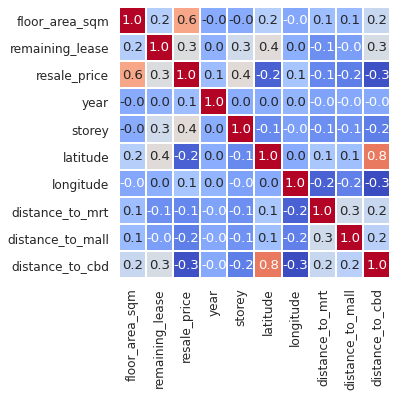

In [ ]:
# Display numerical-to-numerical correlations (pearson correlation) between features on heatmap
sns.set(font_scale=1.1)
correlation_data = df_complete.corr()
mask = np.triu(correlation_data.corr())
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_data,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            # mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

####**Numerical Features - Scatterplot**

**Observations:**
* Most HDBs are within 2.5km from an MRT. However, in Pasir Ris town, there is a cluster of units that are extremely far (>3km) from the nearest MRT. Digging deeper, we see that these are the cluster of shophouse HDBs in Changi Village, where the nearest MRT is Changi Airport.
* Compared to the distance to MRT and mall, the distance to CBD feature is very distinct- closer towns are clearly valued in a higher tier compared to more distant towns.

In [ ]:
# import plotly.express as px
# fig = px.scatter(df_complete,
#                  x='distance_to_mrt', 
#                  y='resale_price',
#                  color='town',
#                  title='HDB Resale PSM vs Distance to MRT')
# fig.show()
# fig = px.scatter(df_complete,
#                  x='distance_to_mall', 
#                  y='resale_price',
#                  color='town',
#                  title='HDB Resale PSM vs Distance to Mall')
# fig.show()
# fig = px.scatter(df_complete,
#                  x='distance_to_cbd', 
#                  y='resale_price',
#                  color='town',
#                  title='HDB Resale PSM vs Distance to CBD')
# fig.show()

**Observations:**
* `floor_area_sqm`: There are some outliers that have extremely large floor areas. These could be jumbo flats comprising 3 and 4 room flats connected together.
* `remaining_lease`: The resale value of a flat drops at the 87 year mark, remains relatively stable until the 65 year mark, then encounters a steep decline as the flat ages.
* `Year`: There is a gradual increase in average flat price over the years.

In [ ]:
# # Plotting numerical features with polynomial order to detect outliers by eye.
# srt_reg('resale_price', df_complete)

####**Categorical Features**

Observations:

* `flat_type`: While the median prices for Multi-Generation and Executive are higher, the highest prices are contributed by 5-Room flats. This is due to the termination of the Executive Apartment model, and only Multi-Gen, 5 room, 4 room, 3 room and 2 room models are newly built. EAs are aging and will depreciate over time. Also, there are very few Multi-Gen transaction in Singapore due to restrictions on buying and selling (Multi-Gen owners can only sell to Mult-Gen families). Also, we find the following association for new flats:
    *  5 Room: 'Improved'
    *  4 Room: 'Model A'
    *  3 Room: 'Model A'
    *  2 Room: '2-room'


In [ ]:
# srt_box('resale_price', df_complete, ['street_name','address'])

###Distribution Analysis

We know that some models fit well to data that are normally distributed. In this chapter, we explore the skewness and kurtosis of the numerical feature distributions in the dataset, and we perform log transformations on them if required.

####**Numerical Features Histogram Plot**

**Observations:**
* Only a number of features seem to have a slightly normal distribution- `resale_price, storey, distance_to_mrt, distance_to_mall and distance_to_cbd`
* The features have different scales, so we should apply a min-max scaler than observe them again.


In [ ]:
# def srt_histo(df, exclude_columns=[]):

#     num_col_names = df.drop(columns=exclude_columns).select_dtypes(include=['number']).columns
#     num_num = len(list(num_col_names))

#     print(f'plotting columns: {num_col_names}')

#     fig, axes = plt.subplots(num_num, 1, figsize=(20, 40))
#     axes = axes.flatten()
#     for i, j in zip(num_col_names, axes):
#         sns.distplot(x=df[i],
#                      ax=j,
#                      axlabel=i
#                      )


# srt_histo(df_complete)

####**Numerical Features Histogram Plot - Post Log Transformation**

In [ ]:
df_skew = df_complete.copy()
skewed = ['storey', 'distance_to_mrt', 'distance_to_mall', 'distance_to_cbd']

# Finding skewness of the numerical features.
skew_features = np.abs(df_skew[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

print(skew_features)

# # Taking indexes of high skew.
skew_index = df_skew.index

# Applying boxcox transformation to fix skewness.
for feature in df_skew[skewed]:
    df_skew[feature] = boxcox1p(df_skew[feature], boxcox_normmax(df_skew[feature] + 1))

# srt_histo(df_skew)


storey              1.574803
distance_to_mall    0.875382
distance_to_mrt     0.827655
distance_to_cbd     0.503589
dtype: float64


####**Numerical Features Histogram Plot - Post Min-Max Scaling**

In [ ]:
def scale_df(df, scaler_type=MinMaxScaler, exclude_columns=[]):
    df_out = df.copy()
    num_col_names = df.drop(columns=exclude_columns).select_dtypes(include=['number']).columns #select num_features
    num_num = len(list(num_col_names))
    for name in num_col_names:
        print(f'scaling {name} feature:')
        scaler = scaler_type()
        df_out[name] = scaler.fit_transform(np.array(df[name]).reshape(-1, 1)) #scale numeric feature

    return df_out

df_scaled = scale_df(df_skew,MinMaxScaler,['resale_price'])
# srt_histo(df_scaled)


scaling floor_area_sqm feature:
scaling remaining_lease feature:
scaling year feature:
scaling storey feature:
scaling latitude feature:
scaling longitude feature:
scaling distance_to_mrt feature:
scaling distance_to_mall feature:
scaling distance_to_cbd feature:


####**Target Variable Log Transformation**

In [ ]:
# def plot_dist3(df, feature, title):
    
#     # Creating a customized chart. and giving in figsize and everything.
#     fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
#     # creating a grid of 3 cols and 3 rows.
#     grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

#     # Customizing the histogram grid.
#     ax1 = fig.add_subplot(grid[0, :2])
    
#     # Set the title.
#     ax1.set_title('Histogram')
    
#     # plot the histogram.
#     sns.distplot(df.loc[:, feature],
#                  hist=True,
#                  kde=True,
#                  fit=norm,
#                  ax=ax1,
#                  color='#e74c3c')
#     ax1.legend(labels=['Normal', 'Actual'])

#     # customizing the QQ_plot.
#     ax2 = fig.add_subplot(grid[1, :2])
    
#     # Set the title.
#     ax2.set_title('Probability Plot')

#         # Plotting the QQ_Plot.
#     stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
#                    plot=ax2)
#     ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
#     ax2.get_lines()[0].set_markersize(12.0)

#     # Customizing the Box Plot:
    
#     ax3 = fig.add_subplot(grid[:, 2])
#     # Set title.
    
#     ax3.set_title('Box Plot')
    
#     # Plotting the box plot.
    
#     sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
#     ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

#     plt.suptitle(f'{title}', fontsize=24)

# plot_dist3(df_scaled, 'resale_price', 'Sale Price Before Log Transformation')

In [ ]:
df_log = df_scaled.copy()
df_log['log_resale_price'] = df_log['resale_price'].apply(lambda x: np.log1p(x)) #compute log(x+1), use np.expm1 for inversion later
scaler = MinMaxScaler() #save this scaler for inversion later
df_log['scaled_log_resale_price'] = scaler.fit_transform(np.array(df_log['log_resale_price']).reshape(-1, 1))
# plot_dist3(df_log, 'log_resale_price', 'Resale Price After Log Transformation')
# plot_dist3(df_log, 'scaled_log_resale_price', 'Resale Price After Min Max Scaled Log Transformation')

# df_test = df_skew.copy()
# df_test['inversed_resale_price'] = scaler.inverse_transform(np.array(df_test['scaled_log_resale_price']).reshape(-1, 1))
# df_test['inversed_resale_price'] = df_test['inversed_resale_price'].apply(lambda x: np.expm1(x))
# plot_dist3(df_test, 'inversed_resale_price', 'Sale Price After Inverse Transformation')



In [ ]:
display(df_log.head())
print(df_log.info())

,town,flat_type,street_name,floor_area_sqm,flat_model,remaining_lease,resale_price,year,storey,address,latitude,longitude,nearest_mrt,distance_to_mrt,nearest_mall,distance_to_mall,distance_to_cbd,log_resale_price,scaled_log_resale_price
0,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,0.059633,Improved,0.320755,232000.0,0.0,0.435539,406 ANG MO KIO AVE 10,0.490783,0.556854,Lorong Chuan,0.761153,AMK Hub,0.578383,0.263440,12.354497,0.230044
1,ANG MO KIO,3 ROOM,ANG MO KIO AVE 4,0.165138,New Generation,0.301887,250000.0,0.0,0.079477,108 ANG MO KIO AVE 4,0.538659,0.504338,Ang Mo Kio,0.230173,AMK Hub,0.636129,0.317642,12.429220,0.264077
2,ANG MO KIO,3 ROOM,ANG MO KIO AVE 5,0.165138,New Generation,0.339623,262000.0,0.0,0.000000,602 ANG MO KIO AVE 5,0.590971,0.495732,Ang Mo Kio,0.722265,AMK Hub,0.816182,0.376219,12.476104,0.285430
3,ANG MO KIO,3 ROOM,ANG MO KIO AVE 10,0.169725,New Generation,0.339623,265000.0,0.0,0.194116,465 ANG MO KIO AVE 10,0.513261,0.567819,Lorong Chuan,0.804087,AMK Hub,0.587337,0.286721,12.487489,0.290616
4,ANG MO KIO,3 ROOM,ANG MO KIO AVE 5,0.165138,New Generation,0.339623,265000.0,0.0,0.000000,601 ANG MO KIO AVE 5,0.592752,0.494951,Ang Mo Kio,0.732662,AMK Hub,0.824558,0.378429,12.487489,0.290616


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98799 entries, 0 to 98798
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   town                     98799 non-null  object 
 1   flat_type                98799 non-null  object 
 2   street_name              98799 non-null  object 
 3   floor_area_sqm           98799 non-null  float64
 4   flat_model               98799 non-null  object 
 5   remaining_lease          98799 non-null  float64
 6   resale_price             98799 non-null  float64
 7   year                     98799 non-null  float64
 8   storey                   98799 non-null  float64
 9   address                  98799 non-null  object 
 10  latitude                 98799 non-null  float64
 11  longitude                98799 non-null  float64
 12  nearest_mrt              98799 non-null  object 
 13  distance_to_mrt          98799 non-null  float64
 14  nearest_mall          

##Modelling

We will attempt to use stacking methods to improve the regression performance. Below is the list of models we can consider as our heterogeneous learners:

* Ridge
* Lasso
* Elasticnet
* SVM
* Gradient Boosting
* LightGBM
* XGBoost

We have some categorical features that have a large number of categories. For instance, `address` has 9044 unique categories, while `street_name` has 552. Applying one-hot encoding to them significantly increases the dimensionality of the input features and most models will not work with such high dimensional inputs.



In [ ]:
def show_feature_dimensionality(df):
    cat_col_names = df.select_dtypes(include=['object']).columns
    for feature in cat_col_names:
        print(f'{feature}: {df[feature].nunique()}')
show_feature_dimensionality(df_log)

town: 26
flat_type: 7
street_name: 552
flat_model: 20
address: 9044
nearest_mrt: 127
nearest_mall: 80


Our plan is to utilise embeddings to reduce the input size and better represent these categorical features.

1. Tokenize categories for each feature and construct an embedding matrix for each feature.
2. Attach the embedding matrix to a two layer Dense network, and train towards an MSE loss function
3. Detach the embedding matrix and freeze the weights
4. Attach frozen embedding matrix to the list of regressors as inputs, then continue with stacking.

**Categorical Features**
* `town`
* `flat_type`
* `street_name`
* `flat_model`
* `address`
* `nearest_mrt`
* `nearest_mall`

**Numerical Features**
* `floor_area_sqm`
* `remaining_lease`
* `year`
* `storey`
* `latitude`
* `longitude`
* `distance_to_mrt`
* `distance_to_cbd`
* `distance_to_mall`

**Target Feature**
* `scaled_log_resale_price`

Here's a log of the experiments we have tried with the embedding-dense model:

* The model MAE remains at 20-23k when embedding dimensions are reduced from 32 dim down to 1 dim. This suggests that the model has not found useful embedding representations.
* What if we remove the numerical features, and force the model to predict purely based on categorical features?
* Excluding numerical features, a run of epoch=10 gives us MAE of 32k. This tells us that the model is indeed starting to learn good representations. The validation loss is higher than train loss, so perhaps we can train for more epochs and see if the MAE can be even lower. If training purely on categorical features work, we can treat it as a pre-training step, and include numerical inptus when finetuning.
* We will next try 1) running more epochs, 2) see the effect of reducing embed dims.
* Running 50 epochs, the MAE lowers to 28.9k. Training loss is still on a gradual decline, and validation loss is also decreasing (has not exceeded train loss). This means we can run for more epochs (200) to see if we can get better results.
* Running 200 epochs gives an MAE of 27.9k. Loss is decreasing very slowly at this point, and MAE is almost stagnant. Surprisingly, validation loss has not increased. Perhaps we could try increasing the capacity of the model (embed_dims and dense nodes), see if it is able to overfit the data.
* Oops, we have been running the past experiments with embed_dims = 1. Im surprised that the model can even learn anything. Now we increase embed_dims to 8, and see if we reduce MAE or overfit the data.
* Increasing to embed_dims = 8 with 200 epochs gives an MAE of 30k. Training and validation loss seems to plateau, but theres no clear signs of overfitting. Perhaps we can double embed_dims and Dense nodes to see if it is the bottleneck. Then again it could be possible that the model is already optimal, and batch_norm and batch_size are helping to prevent severe overfitting.
* Doubling embed_dims and Dense nodes dont seek to make much of a difference, MAE is around 28.9k. Guess theres not much else to learn from the data, increasing capacity does not lead to overfitting nor lower losses, and losses plateau before epoch 100. This could mean we have already optimised the embedding representations.
* Now there are 3 things to find out. 1) What is the baseline performance for numerical data, when categorical data is removed. 2) Does MAE improve if we reintroduce numerical data with these pretrained embeddings, 3) Which is better? To freeze embedding layer training or continue embedding layer training when numerical features are added?
* Using numerical data alone for 100 epochs gives us 25k MAE.
* We try removing batchnorm layers and increase model capacity to 200 nodes/layer and 3 Dense layers to encourage overfitting. Model attains a new lowest loss of 0.0010, and a MAE of 24.4k. It is still not overfitting at this point since val MAE is at 0.0010 as well. We will try training 200 epochs to see how much lower we can go.
* Pushing it to 200 epochs, we arrive at a loss plateau of 23.3k MAE.Next, lets try to do the same for purely categorical features.
* Using purely categorical features, we manage to achieve clear overfitting. MAE remains at 28k, and val loss is at 0.0014. train loss is however at 0.0010. Let's try training both numerical and categorical features together next, see how low we can overfit this time.
* With both categorical and numerical features, we achieve a lowest MAE of $21k. However there is severe overfitting at epoch 200. Train loss goes down to 2.4e-4 and val loss goes down to 8.87e-4.
* Now we try pretraining on categorical features first, freeze the weights, then train with numerical features.

In [ ]:
class Embedder:
    def __init__(self, neptune_runner=None):
        self.model = None   # post-fit model
        self.history = None # post-fit training history 
        self.encoders = None # encoders applied on categorical features
        self.scaler = None # scaler applied on target variable
        self.embedding_dim = None
        self.X_test_dict = None
        self.Y_test = None
        self.embedding_weights = None
        self.neptune_runner = neptune_runner
    
    def fit(self, X, Y, batch_size=64, epochs=1, embedding_dim=8, use_numerical=False, use_batch_norm=True):

        if self.neptune_runner is not None: #do logging only if neptune runner is provided
            run = self.neptune_runner
            logger = self.NeptuneLogger()
            run['parameters/epochs'] = epochs
            run['parameters/batch_size'] = batch_size
            run['parameters/embedding_dim'] = embedding_dim
            run['parameters/use_numerical'] = use_numerical
            run['parameters/use_batch_norm'] = use_batch_norm

        df_X = X.copy()
        df_Y = Y.copy()

        X_train_num, X_train_cat, X_test_num, X_test_cat, Y_train, Y_test, X_train_dict, X_test_dict = self.__preprocess_data(df_X, df_Y)

        self.X_test_dict = X_test_dict
        self.Y_test = Y_test

        print(f'Fitting embedder...')
        print(f'Training Set Size: {len(X_train_cat)}')
        print(f'Test Set Size: {len(X_test_cat)}')

        self.embedding_dim = embedding_dim

        # prepare model
        tf.keras.backend.clear_session()
        embedding_out = [] 
        inputs = []

        # ingest encoded categorical features to embedded network
        for category in X_train_cat:
            # Encode over the full dataset to avoid having to deal with oov issues
            vocab_size = df_X[category].nunique() 
            
            # Build embedding layers
            input_cat = tf.keras.layers.Input(shape=(1,), name='input_'+str(category)) #this is to link feature to input later
            embed = tf.keras.layers.Embedding(vocab_size, embedding_dim, trainable=True, embeddings_initializer=tf.initializers.random_normal())(input_cat)
            embed_reshaped = tf.keras.layers.Reshape(target_shape=(embedding_dim,))(embed)
            embedding_out.append(embed_reshaped) #consolidate the embedding outputs in a list

            #consolidate input feeds in a list
            inputs.append(input_cat) 

        # ingest numeric features to network
        if use_numerical:
            input_num = tf.keras.layers.Input(shape=len(X_train_num.columns), name='input_numerical')
            embedding_out.append(input_num)
            inputs.append(input_num)

        # concatenate numerical and categorical input models
        merged_inputs = tf.keras.layers.concatenate(embedding_out)

        # add fully connected layers
        d = tf.keras.layers.Dense(200, activation='relu')(merged_inputs)
        if use_batch_norm:
            d = tf.keras.layers.BatchNormalization()(d) #batch norms helps prevent overfit
        d = tf.keras.layers.Dense(200, activation='relu')(d)
        if use_batch_norm:
            d = tf.keras.layers.BatchNormalization()(d)
        d = tf.keras.layers.Dense(200, activation='relu')(d)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(d) #sigmoid for regression

        model = tf.keras.models.Model(inputs=inputs, outputs=output) #define where the model begins and ends

        # compile model
        optimizer = tf.keras.optimizers.Adam(lr=1e-2)
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

        # prepare model visualisation
        # print(model.summary())
        # dot_img_file = 'model.png'
        # tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

        #fit model
        history = model.fit(X_train_dict, 
                            Y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, #batching helps prevent overfit
                            validation_data=(X_test_dict, Y_test), 
                            verbose=2,
                            callbacks=[logger])

        # Extract weights from embedding layers
        embedding_weights = []
        for layer in model.layers:
            if('embedding' in layer.name):
                embedding_weights.append(layer.get_weights())
        
        self.embedding_weights = embedding_weights
        self.model = model
        self.history = history
        return

    def transform(self, X):
        print('Transforming inputs...')
        df_X = X.copy()

        #transform maps the inputs to the concatenated embedding_out layer.
        X_num, X_cat, X_dict = self.__preprocess_data(df_X)
        
        # prepare model
        embedding_dim = self.embedding_dim
        embedding_out = [] 
        inputs = []

        # ingest encoded categorical features to embedded network
        for index, category in enumerate(X_cat):
            # Encode over the full dataset to avoid having to deal with oov issues
            vocab_size = df_X[category].nunique() 
            
            # Build embedding layers
            input_cat = tf.keras.layers.Input(shape=(1,), name='input_'+str(category)) #this is to link feature to input later
            embed = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=self.embedding_weights[index], trainable=False, embeddings_initializer=tf.initializers.random_normal())(input_cat)
            embed_flat = tf.keras.layers.Reshape(target_shape=(embedding_dim,))(embed)
            embedding_out.append(embed_flat) #consolidate the embedding outputs in a list

            #consolidate input feeds in a list
            inputs.append(input_cat) 

        # # ingest numeric features to network
        input_num = tf.keras.layers.Input(shape=len(X_num.columns), name='input_numerical')
        embedding_out.append(input_num)
        inputs.append(input_num)

        # concatenate numerical and categorical input models
        output = tf.keras.layers.concatenate(embedding_out)
        model = tf.keras.models.Model(inputs=inputs, outputs=output) #define where the model begins and ends

        #transform df_X to embedded form
        out = model.predict(X_dict) 
        df_out = pd.DataFrame(out)
        return df_out

    def fit_transform(self, X, Y,batch_size=64, epochs=1, embedding_dim=8):
        df_X = X.copy()
        df_Y = Y.copy()
        self.fit(df_X, df_Y, batch_size, epochs, embedding_dim)
        return self.transform(df_X)

    def predict(self, X_test):
        return self.transform(X_test)

    def __preprocess_data(self,X,Y=None):
        df_X = X.copy()
        # encode categorical features - common to fit() and transform()
        encoders = []
        df_cat = df_X.select_dtypes(include=['object'])
        for feature in df_cat:
            encoder = LabelEncoder()
            df_X[feature] = encoder.fit_transform(df_X[feature])
            encoder_dict = {    
                'name': feature,
                'feature_encoder': encoder
            }
            encoders.append(encoder_dict)
        self.encoders = encoders #store encoders for reconstruction later

        if Y is None: # preprocessing for transform()
            X_num = df_X.select_dtypes(include=['float64'])
            X_cat = df_X.select_dtypes(include=['int64'])
            X_dict = {}

            #feed categorical inputs to model inputs
            for category in X_cat:
                X_dict['input_'+category] = X_cat[category]

            #feed numerical inputs to model inputs
            X_dict['input_numerical'] = X_num

            return X_num, X_cat, X_dict

        else: # preprocessing for fit() 
            df_Y = Y.copy()

            # log transform target variable
            df_Y = df_Y.apply(lambda x: np.log1p(x)) #compute log(x+1), use np.expm1 for inversion later
     
            # scale target variable
            scaler = MinMaxScaler()
            df_Y = scaler.fit_transform(np.array(df_Y).reshape(-1, 1))
            self.scaler = scaler

            # split train test sets and seperate by numerical and categorical features
            X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2)
            X_train_num = X_train.select_dtypes(include=['float64'])
            X_train_cat = X_train.select_dtypes(include=['int64'])
            X_test_num = X_test.select_dtypes(include=['float64'])
            X_test_cat = X_test.select_dtypes(include=['int64'])

            X_train_dict = {}
            X_test_dict = {}
            #feed categorical inputs to model inputs
            for category in X_train_cat:
                X_train_dict['input_'+category] = X_train_cat[category]
                X_test_dict['input_'+category] = X_test_cat[category]

            #feed numerical inputs to model inputs
            X_train_dict['input_numerical'] = X_train_num
            X_test_dict['input_numerical'] = X_test_num

            return X_train_num, X_train_cat, X_test_num, X_test_cat, Y_train, Y_test, X_train_dict, X_test_dict

    class NeptuneLogger(Callback):
        def on_batch_end(self, batch, logs={}):
            for log_name, log_value in logs.items():
                run['batch/{}'.format(log_name)].log(log_value)

        def on_epoch_end(self, epoch, logs={}):
            for log_name, log_value in logs.items():
                run['epoch/{}'.format(log_name)].log(log_value)

    def projector(self):
        for index, encoder in enumerate(self.encoders): #for each categorical feature
            category = encoder['name']
            out_v = io.open(category+'_vecs.tsv', 'w', encoding='utf-8')
            out_m = io.open(category+'_meta.tsv', 'w', encoding='utf-8')
            vocab_size = np.array(self.embedding_weights[index]).shape[1]
            word_indexes = np.arange(vocab_size)
            words = encoder['feature_encoder'].inverse_transform(word_indexes)

            for idx, word in enumerate(words):
                embeddings = np.array(self.embedding_weights[index][0][idx])
                out_m.write(word + "\n")
                out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

            out_v.close()
            out_m.close()
        print('Projection .tsv files updated.')
        return

    def plot_losses(self):
        if self.history is None:
            print('Error: Embedder has not been fitted.')
            return

        print('Plotting training loss...')
        history = self.history
        mae=history.history['mae']
        val_mae=history.history['val_mae']
        loss=history.history['loss']
        val_loss=history.history['val_loss']

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        epochs=range(len(loss)) # Get number of epochs

        plt.plot(epochs, mae, 'r')
        plt.plot(epochs, val_mae, 'b')
        plt.title('Training and validation MAE')
        plt.xlabel("Epochs")
        plt.ylabel("MAE")
        plt.legend(["MAE", "Validation MAE"])
        plt.axes(axes[0])

        plt.plot(epochs, loss, 'r')
        plt.plot(epochs, val_loss, 'b')
        plt.title('Training and validation loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Loss", "Validation Loss"])
        plt.axes(axes[1])
        plt.figure()
        return

    def plot_metrics(self):
        if (self.X_test_dict is None) or (self.Y_test is None) or (self.model is None):
            print('Error: Embedder has not been fitted.')
            return 

        print('Plotting training metrics...')
        # Check prediction performance
        Y_pred = self.model.predict(self.X_test_dict)

        # Inverse scaling and log transformations
        Y_pred_inv = np.expm1(self.scaler.inverse_transform(Y_pred))
        Y_test_inv = np.expm1(self.scaler.inverse_transform(self.Y_test.reshape(-1, 1)))
        mae = int(mean_absolute_error(Y_test_inv, Y_pred_inv))
        print(f'MAE: S${mae}')

        fig = plt.figure(figsize=(15,5))
        plt.title("Actual vs predicted housing prices")
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.scatter(x=Y_test_inv, y=Y_pred_inv, c='b', label="NN")
        plt.legend(loc='upper left')
        plt.show()

        if self.neptune_runner is not None: #do logging only if neptune runner is provided
            run = self.neptune_runner
            run['test/mae'] = mae
            run['test/scatter_chart'].log(neptune.types.File.as_image(fig))
        
        return mae

In [ ]:
with open(drive_path+'neptune_api_token.pickle', 'rb') as f:
    api_token = pickle.load(f)

run = neptune.init(project="leejielong/hdbnet-embedder", api_token=api_token)
run["sys/name"] = 'first-run' #describe current experiment
# run["sys/tags"].add('') #add tag to current experiment


https://app.neptune.ai/leejielong/hdbnet-embedder/e/HDBEMBED-1


Fitting embedder...
Training Set Size: 79039
Test Set Size: 19760
Epoch 1/100
1235/1235 - 7s - loss: 0.0039 - mae: 0.0432 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 2/100
1235/1235 - 5s - loss: 0.0018 - mae: 0.0333 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 3/100
1235/1235 - 5s - loss: 0.0016 - mae: 0.0312 - val_loss: 0.0016 - val_mae: 0.0306
Epoch 4/100
1235/1235 - 5s - loss: 0.0015 - mae: 0.0300 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 5/100
1235/1235 - 5s - loss: 0.0014 - mae: 0.0295 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 6/100
1235/1235 - 6s - loss: 0.0014 - mae: 0.0287 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 7/100
1235/1235 - 6s - loss: 0.0013 - mae: 0.0282 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 8/100
1235/1235 - 5s - loss: 0.0013 - mae: 0.0278 - val_loss: 0.0014 - val_mae: 0.0294
Epoch 9/100
1235/1235 - 6s - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 10/100
1235/1235 - 5s - loss: 0.0012 - mae: 0.0272 - val_loss: 0.0014 - val_mae: 0.0295
Epo

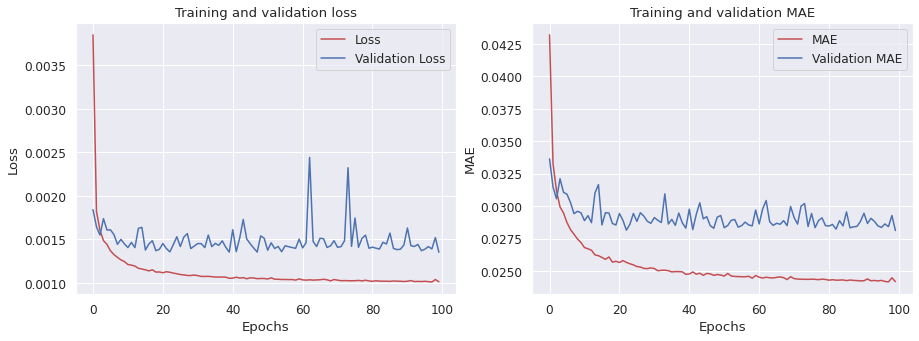

<Figure size 432x288 with 0 Axes>

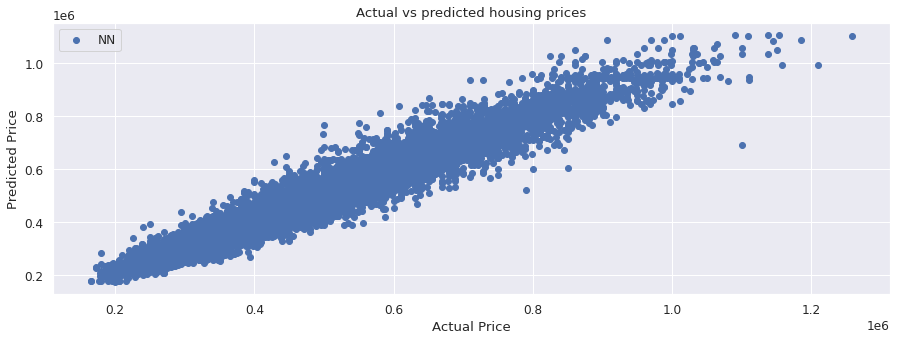

Projection .tsv files updated.


In [ ]:
df_Y = df_log['resale_price']
df_X = df_log.drop(columns=['scaled_log_resale_price','log_resale_price','resale_price'])

embedder = Embedder(run)
embedder.fit(df_X, df_Y, batch_size=64, epochs=100, embedding_dim=8) #fit needs to take in X and Y
df_out = embedder.transform(df_X)
embedder.plot_losses()
embedder.plot_metrics()
embedder.projector()

Now let's learn how to use neptune.ai to track our experiments, then we log some of the embedder experiments into neptune.

In [ ]:
#test if Embedding class works in sklearn pipeline- IT WORKS!
#integrate with the suite of models and do a stacked cv

from sklearn.pipeline import Pipeline
pipe = Pipeline([
                 ('embedder', Embedder())
                 ])

pipe.fit(df_X, df_Y)



Fitting embedder...
Training Set Size: 79039
Test Set Size: 19760
1235/1235 - 7s - loss: 0.0037 - mae: 0.0431 - val_loss: 0.0019 - val_mae: 0.0338


Pipeline(memory=None,
         steps=[('embedder', <__main__.Embedder object at 0x7f27887ba7d0>)],
         verbose=False)

In [ ]:
test = pipe.transform(df_X)
print(test)

Transforming inputs...
             0         1         2   ...        62        63        64
0     -0.007996  0.116344 -0.111757  ...  0.761153  0.578383  0.263440
1     -0.007996  0.116344 -0.111757  ...  0.230173  0.636129  0.317642
2     -0.007996  0.116344 -0.111757  ...  0.722265  0.816182  0.376219
3     -0.007996  0.116344 -0.111757  ...  0.804087  0.587337  0.286721
4     -0.007996  0.116344 -0.111757  ...  0.732662  0.824558  0.378429
...         ...       ...       ...  ...       ...       ...       ...
98794  0.205622  0.059237  0.054249  ...  0.722042  0.381406  0.698160
98795  0.205622  0.059237  0.054249  ...  0.830545  0.567612  0.694406
98796  0.205622  0.059237  0.054249  ...  0.836369  0.626952  0.674545
98797  0.205622  0.059237  0.054249  ...  0.678467  0.303263  0.704378
98798  0.205622  0.059237  0.054249  ...  0.484871  0.468903  0.686415

[98799 rows x 65 columns]


In [ ]:
# # store logs in experiment_logs.pickle

# def log_experiment(model_layers, history, mae, clear=False):
#     experiment = {
#         'description': input(),
#         'model_layers': model_layers,
#         'history': history,
#         'result' : mae,
#         'timestamp': datetime.now()
#     }

#     # if clear:
#     #     with open(drive_path+'experiment_logs.pickle', 'rwb') as f:
#     #         experiments = []
#     #         pickle.dump(experiments, f)

#     print(experiment)

#     # if (not os.path.isfile(drive_path+'experiment_logs.pickle'):
#     #     experiments = []
#     #     experiments.append(experiment)
#     #     with open(drive_path+'experiment_logs.pickle', 'rwb') as f:
#     #         pickle.dump(experiments, f)
#     # else:
#     #     with open(drive_path+'experiment_logs.pickle', 'rwb') as f:
#     #         experiments = pickle.load(f)
#     #         experiments.append(experiment)
#     #         pickle.dump(experiments, f)

#     return experiment

# log_experiment(model.layers, history, mae)



**Side-thought**: When usually like to modify certain parameters and re-run our experiments. Could it be useful to save our experiments in a list of dicts accumulatively so that we can plot and track them later? We dont want to automate the experiment process- in each experiment we could change different things depending on our observations, and running n experiments in a go takes a long time and is not feasible for colab environments.

Maybe this is what tensorboard does- might help to check if this can be done.

Idea:

```
[
    {
        'description': 'removed categorical features',
        'model': model,
        'history': history,
        'result': [y_pred, y_test],
        'datetime': datetime
    },
    {
        'description': 'increased to 200 epochs',
        'model': model,
        'history': history,
        'result': [y_pred, y_test],
        'datetime': datetime
    },   
]
```

This allows us to compare results at a later stage once all the experiements are complete. The user has to add in a description (similar to a commit description) to explain what variable was changed. 

